In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17661438933640759472
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17900845981252932068
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 18347979329411768725
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15701463552
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6775956892417930070
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [3]:
# import numpy as np
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# import nltk
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.preprocessing import LabelBinarizer
# from nltk.corpus import stopwords
# from nltk.stem.porter import PorterStemmer
# from wordcloud import WordCloud,STOPWORDS
# from nltk.stem import WordNetLemmatizer
# from nltk.tokenize import word_tokenize,sent_tokenize
# from bs4 import BeautifulSoup
# import re,string,unicodedata
# from nltk.tokenize.toktok import ToktokTokenizer
# from nltk.stem import PorterStemmer,WordNetLemmatizer
# from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
# from sklearn.model_selection import train_test_split
# from string import punctuation
# from nltk import pos_tag
# from nltk.corpus import wordnet
# import keras
# from keras.models import Sequential
# from keras.layers import Dense
# import tensorflow as tf

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [4]:
# !wget http://nlp.stanford.edu/data/glove.twitter.27B.zip

In [5]:
# !unzip glove*.zip -d '/content/gdrive/My Drive/twitter misinfo/'

In [6]:
real = pd.read_csv('/content/gdrive/My Drive/twitter misinfo/2020_04_10000_real_tweets.csv', header = None)
fake = pd.read_csv('/content/gdrive/My Drive/twitter misinfo/2020_04_10000_fake_tweets_unconditional.csv', header = None)


In [7]:
real.columns = ['tweet']

In [8]:
real['index'] = real.index

In [9]:
fake.columns = ['tweet']
fake['index'] = fake.index

In [10]:
cols = real.columns.tolist()
cols = cols[-1:] + cols[:-1]

In [11]:
real = real[cols]

In [12]:
cols = fake.columns.tolist()
cols = cols[-1:] + cols[:-1]
fake = fake[cols]

In [13]:
real['category'] = 1
fake['category'] = 0
real.head()

,index,tweet,category
0,0,#Taiwan isn't a member of the #WHO. Taiwan tr...,1
1,1,From the DJs to the CJs.. Look whose in the PJ...,1
2,2,The @ClinicalBioinfo led by @xdopazo releases ...,1
3,3,IMF expects #Greece to be the worst hit econom...,1
4,4,More on #COVID19 - China witnessed a slight in...,1


In [14]:
fake.head()

,index,tweet,category
0,0,@chrislhayes I think it's important to note th...,0
1,1,"The problem is, it's the Chinese that are bein...",0
2,2,Do you know of any people who are looking for ...,0
3,3,Just as the COVID-19 pandemic has shown that t...,0
4,4,Covid-19's impact on the economy: The RBC Stat...,0


In [15]:
fake['tweet'][0]

"@chrislhayes I think it's important to note that there are two big areas that need to be addressed. First, the coronavirus and the existing system. Second, the existing system and health systems.  The first is very, very important, and that's a big concern. "

In [16]:
combined = pd.concat([fake, real])
features = combined['tweet']
labels = combined['category']
combined = combined.sample(frac = 1).reset_index(drop = True)
combined['index'] = combined.index
combined.tail()
combined.isna().sum()
combined.dropna(axis = 0)

,index,tweet,category
0,0,Cristiano Ronaldo - fitness challenge #Cristi...,1
1,1,Amsterdam to embrace 'doughnut' model to mend ...,1
2,2,“There are more than 200 deaths in 24 hours. B...,0
3,3,@Shumona13 @LatofaOb Happy Friday Stay Home,1
4,4,@cyrillic You were supposed to have a show at ...,0
...,...,...,...
19992,19992,@zeefa64 Do countries with high rates of malar...,1
19993,19993,How to stay festive while you #stayhome: 1. ...,1
19994,19994,Coronavirus update:,0
19995,19995,@Lyca3 @ZimDulawy @MattHancock It is just so e...,0


In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

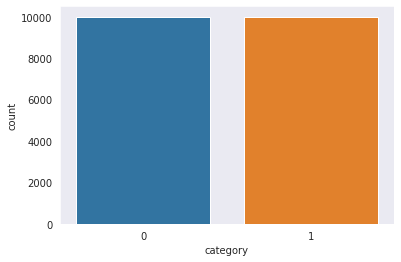

In [18]:
sns.set_style("dark")
sns.countplot(combined.category)

In [19]:
# combined['tweet'] = combined['tweet'].astype(str).str.replace('[^a-zA-Z]',' ').str.lower()

In [20]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [21]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(str(text))
    text = remove_between_square_brackets(str(text))
    text = remove_stopwords(str(text))
    return text
#Apply function on review column
combined['tweet']=combined['tweet'].apply(denoise_text)

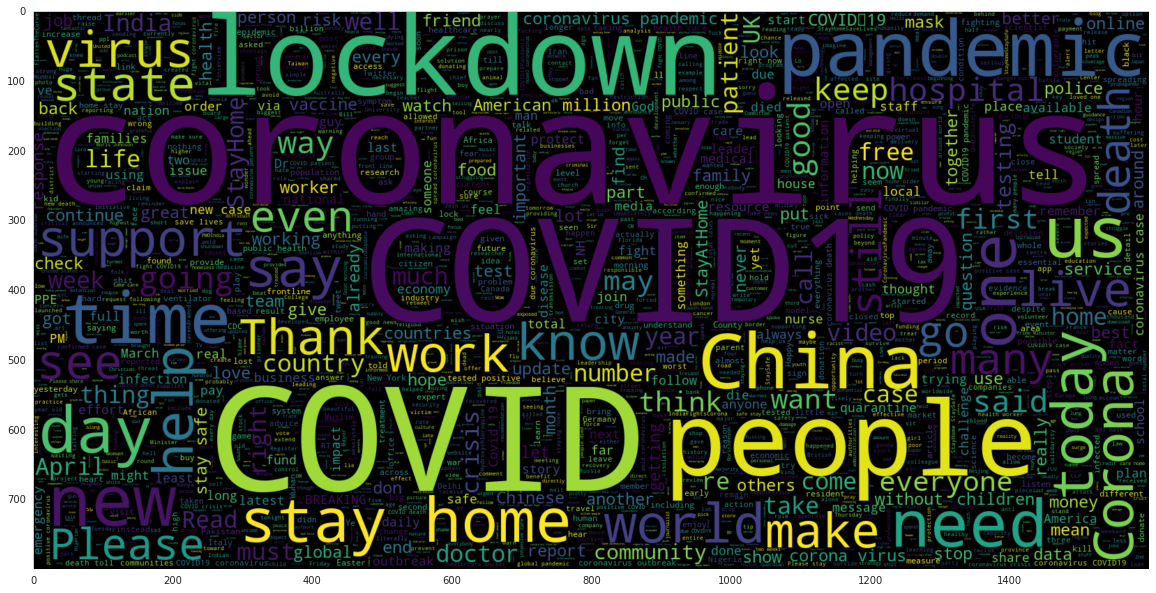

In [22]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(combined[combined.category == 1].tweet))
plt.imshow(wc , interpolation = 'bilinear')

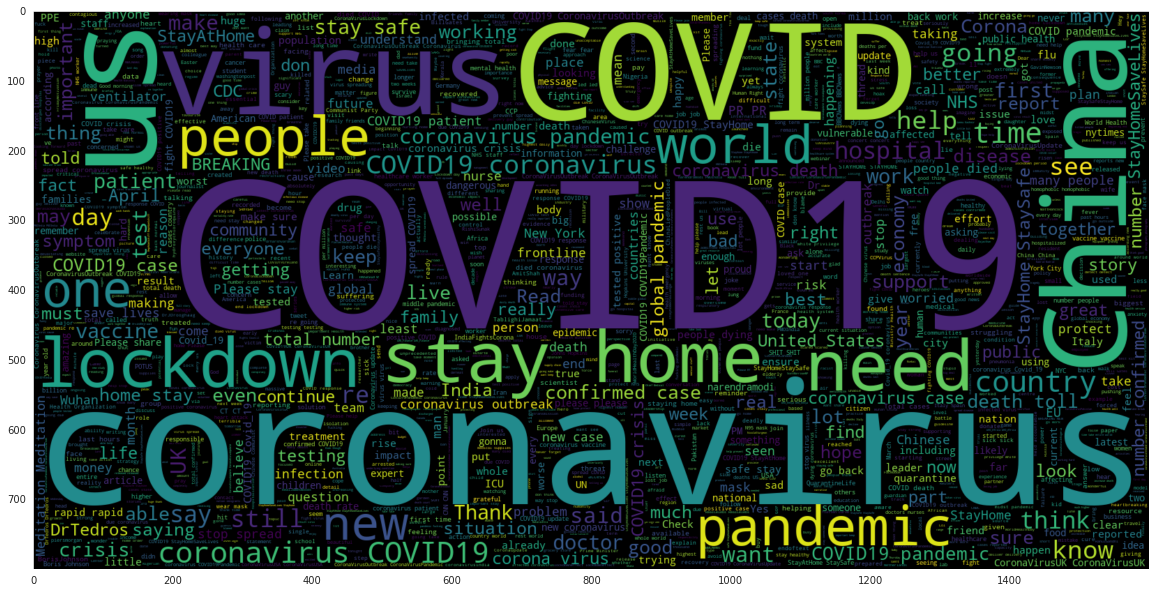

In [23]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(combined[combined.category == 0].tweet))
plt.imshow(wc , interpolation = 'bilinear')

In [24]:
x_train,x_test,y_train,y_test = train_test_split(combined.tweet,combined.category,random_state = 0)

In [25]:
import numpy as np

measurer = np.vectorize(len)

res1 = measurer(combined.values.astype(str)).max(axis=0)
res2 = measurer(combined.values.astype(str)).min(axis=0)
print(res1, "\n", res2)

[   5 1041    1] 
 [1 0 1]


In [26]:
max_features = 10000
maxlen = 520

In [27]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [28]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [29]:
EMBEDDING_FILE = '/content/gdrive/My Drive/twitter misinfo/glove.twitter.27B.200d.txt'

In [30]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [31]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [32]:
batch_size = 256
epochs = 10
embed_size = 200

In [33]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [34]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 520, 200)          2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 520, 128)          168448    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,219,969
Trainable params: 219,969
Non-trainable params: 2,000,000
_________________________________________________________________


In [36]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction])

Train on 14997 samples, validate on 5000 samples
Epoch 1/10
14997/14997 [==============================] - 108s 7ms/step - loss: 0.6193 - accuracy: 0.6415 - val_loss: 0.5688 - val_accuracy: 0.6856
Epoch 2/10
14997/14997 [==============================] - 106s 7ms/step - loss: 0.5308 - accuracy: 0.7325 - val_loss: 0.5139 - val_accuracy: 0.7498
Epoch 3/10
14997/14997 [==============================] - 106s 7ms/step - loss: 0.4808 - accuracy: 0.7710 - val_loss: 0.4700 - val_accuracy: 0.7738
Epoch 4/10
14997/14997 [==============================] - 107s 7ms/step - loss: 0.4410 - accuracy: 0.7912 - val_loss: 0.4678 - val_accuracy: 0.7760
Epoch 5/10
14997/14997 [==============================] - 105s 7ms/step - loss: 0.4104 - accuracy: 0.8100 - val_loss: 0.4814 - val_accuracy: 0.7788
Epoch 6/10
14997/14997 [==============================] - 106s 7ms/step - loss: 0.3710 - accuracy: 0.8297 - val_loss: 0.4572 - val_accuracy: 0.7870
Epoch 7/10
14997/14997 [==============================] - 107s 

In [37]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100)

14997/14997 [==============================] - 69s 5ms/step
Accuracy of the model on Training Data is -  96.23924493789673
5000/5000 [==============================] - 23s 5ms/step
Accuracy of the model on Testing Data is -  77.97999978065491


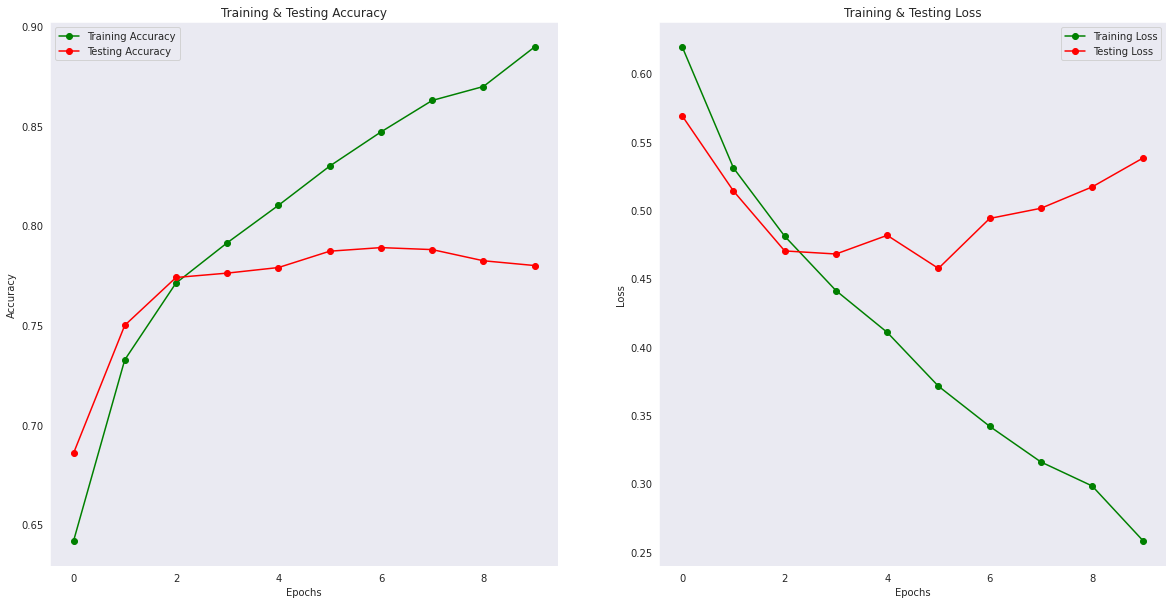

In [38]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [39]:
pred = model.predict_classes(X_test)
pred[:5]

array([[1],
       [1],
       [0],
       [0],
       [0]], dtype=int32)

In [40]:
print(classification_report(y_test, pred, target_names = ['Fake','Not Fake']))

              precision    recall  f1-score   support

        Fake       0.76      0.82      0.79      2521
    Not Fake       0.80      0.74      0.77      2479

    accuracy                           0.78      5000
   macro avg       0.78      0.78      0.78      5000
weighted avg       0.78      0.78      0.78      5000



In [41]:
cm = confusion_matrix(y_test,pred)
cm

array([[2069,  452],
       [ 649, 1830]])

In [42]:
cm = pd.DataFrame(cm , index = ['Fake','Not Fake'] , columns = ['Fake','Not Fake'])

Text(69.0, 0.5, 'Predicted')

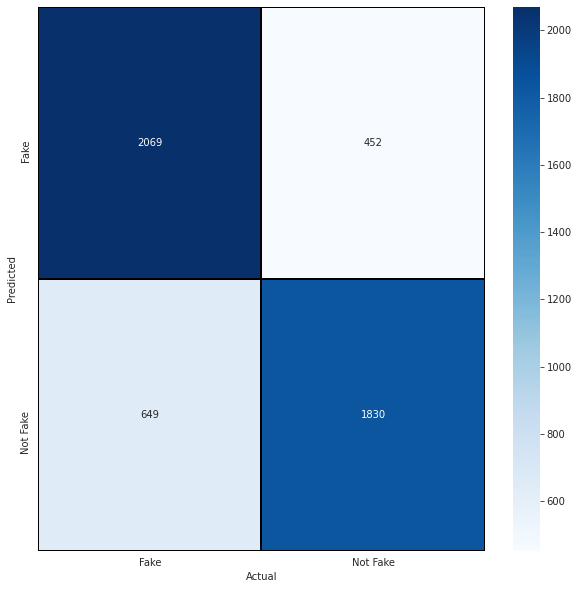

In [43]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Not Fake'] , yticklabels = ['Fake','Not Fake'])
plt.xlabel("Actual")
plt.ylabel("Predicted")